# ForceField Parameter Deduplication
## Authors: Connor Davel, Jeffrey Wagner
## Date Created: April 21, 2021
One inefficiency in the current forcefields is redudant parameters. These add an estimated 10 to 20% loading time during the very slow `ForceField.create_openmm_system()` function, not to mention any other function that need to load and parse the file. Since searching and operating on large forcefield files tends to be more than linearly complex, it is important that the user is given the shortest forcefield parameter file possible while also maintaining the same results no matter the chemical environment. The goal of this notebook is to reduce the size of `test.offxml` and produce the same energy calculations for the ALA_ALA protein and t4 protein files. 

## Forcefield reduction methods
Any two identical smirks should have the same parameters, so one of these smirks can be safely removed without changing how the system is parameterized. For example, the first two bonds in `test.offxml` are equivalent:

`<Bond smirks="[H][C@@]([C]=O)([C:1]([H:2])([H])[S])[N][H]" length="1.09 * angstrom" k="680.0 * angstrom**-2 * mole**-1 * kilocalorie" id="A14SB-MainChain_CYX-2C_H1"></Bond>`

`<Bond smirks="[H][C@@]([C]=O)([C:1]([H])([H:2])[S])[N][H]" length="1.09 * angstrom" k="680.0 * angstrom**-2 * mole**-1 * kilocalorie" id="A14SB-MainChain_CYX-2C_H1"></Bond>`

The only difference between the two smirks is which identical hydrogen is mapped. Changing the mapping or which specific hydrogen is bonded to carbon does not change the structure or the bond values (length, k, etc.). Identical smirks are recognized with two methods:

1) MCS substructure searching with as custom isotope search function

2) isomorphism test adapted from `Molecule.are_isomorphic()` (Same method but used RDKit instead of Molecule)

Throughout the notebook, I avoided using the `Molecule` or `FrozenMolecule` since these classes do not play nicely with wild-type bonds. I used RDKit for the MCS seraching and isomorphism, so free users can use this notebook. 
		

## Importing dependences and loading forcefield

In [1]:
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
import parmed as ParmEd
from simtk import openmm
from simtk.openmm import app, unit, XmlSerializer, LangevinIntegrator
from simtk.openmm.app import NoCutoff, HBonds
import os, sys
import itertools
import time
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdFMCS
from networkx.algorithms.isomorphism import GraphMatcher

cdir = Path.cwd()
sys.path.append(str(cdir.parents[0]))
from utils import fix_carboxylate_bond_orders
from amberimpropertorsionhandler import AmberImproperTorsionHandler

# create the forcefield
ff = ForceField('test.offxml', 'test_backbone.offxml')

## Define function that will compare smirks:
'smirks_are_equivalent`: returns True if smirks are chemically equivalent, False else

'isomorphic_test`: used by `smirks_are_equivalent` to do the isomorphism test using networkx 

In [2]:
def isomorphic_test(qmol1, qmol2):

    # Build the user defined matching functions
    def node_match_func(x, y):
        is_equal = x["atomic_number"] == y["atomic_number"]
        is_equal &= x["is_aromatic"] == y["is_aromatic"]
        is_equal &= x["formal_charge"] == y["formal_charge"]
        is_equal &= x["stereochemistry"] == y["stereochemistry"]
        is_equal &= x["atom_map_num"] == y["atom_map_num"]
        return is_equal

    def edge_match_func(x, y):
        is_equal = (x["is_aromatic"] == y["is_aromatic"]) or (
            x["bond_order"] == y["bond_order"]
        )
        is_equal &= x["stereochemistry"] == y["stereochemistry"]
        return is_equal

    # Here we should work out what data type we have, also deal with lists?
    def qmol_to_networkx(qmol):
        try:
            import networkx as nx
            from networkx.algorithms.isomorphism import GraphMatcher
        except ImportError as e:
            print(e)
            print("networkx import error in reduce_forcefield()")
            return None
        G = nx.Graph()
        for atom in qmol.GetAtoms():
            G.add_node(
                atom.GetIdx(),
                atomic_number=atom.GetAtomicNum(),
                is_aromatic=atom.GetIsAromatic(),
                stereochemistry=atom.GetChiralTag(),
                formal_charge=atom.GetFormalCharge(),
                atom_map_num=(atom.GetAtomMapNum() != 0),
            )
        for bond in qmol.GetBonds():
            G.add_edge(
                bond.GetBeginAtomIdx(),
                bond.GetEndAtomIdx(),
                bond_order=bond.GetBondType(),
                is_aromatic=bond.GetIsAromatic(),
                stereochemistry=bond.GetStereo(),
            )
        return G

    mol1_netx = qmol_to_networkx(qmol1)
    mol2_netx = qmol_to_networkx(qmol2)

    GM = GraphMatcher(
        mol1_netx, mol2_netx, node_match=node_match_func, edge_match=edge_match_func
    )
    isomorphic = GM.is_isomorphic()

    return isomorphic

def smirks_are_equivalent(smirks1, smirks2, error_flagging=False, method='all'):
    """
    sm1: smirks string 1
    sm2: smirks string 2
    error_flagging: False to return only bool result, True to print basis debugging info
    method: MCS for maximum substructure comparison,
            ISO for isomorphism comparison,
            all to use all comparison methods at once
    returns: True if sm1 and sm2 are equivalent, False else
    """

    mcs_equivalent = True
    isomorph_equivalent = True
    if method == 'MCS' or method == 'all':
        # implement maximum common substructure check
        qmol1 = Chem.MolFromSmarts(smirks1)
        qmol2 = Chem.MolFromSmarts(smirks2)

        mapped_idx_multiple = 300 # arbitrary multiple to distiguish mapped atoms
        for at_idx, at in enumerate(qmol1.GetAtoms()):
            map_num = at.GetAtomMapNum()
            if map_num != 0:
                at.SetIsotope(mapped_idx_multiple * map_num + int(at.GetAtomicNum()))
            else:
                at.SetIsotope(int(at.GetAtomicNum()))
                pass

        for at_idx, at in enumerate(qmol2.GetAtoms()):
            map_num = at.GetAtomMapNum()
            if map_num != 0:
                at.SetIsotope(mapped_idx_multiple * map_num + int(at.GetAtomicNum()))
            else:
                at.SetIsotope(int(at.GetAtomicNum()))
                pass
        res=rdFMCS.FindMCS([qmol1, qmol2], atomCompare=(rdFMCS.AtomCompare.CompareIsotopes))
        # is the mcs structure just as large as the two smarts structures
        mcs_equivalent = (res.numAtoms == qmol1.GetNumAtoms() == qmol2.GetNumAtoms())
    if method == 'ISO' or method == 'all':
        # implement isomorphism check similar to Molecule.are_isomorphic()
        qmol1 = Chem.MolFromSmarts(smirks1)
        qmol2 = Chem.MolFromSmarts(smirks2)

        isomorph_equivalent = isomorphic_test(qmol1, qmol2)


    if error_flagging:
        if mcs_equivalent and isomorph_equivalent:
            print("smirks found to be equivalent")
        else:
            print("smirks found not to be equivalent")
            print(f"\tmcs_equivalent: {mcs_equivalent}\tisomorph_equivalent: {isomorph_equivalent}")
            print("Mass info compared by rdFMCS:")
            print([at.GetIsotope() for at in qmol1.GetAtoms()])
            print([at.GetIsotope() for at in qmol2.GetAtoms()])
            print("res map:")
            print(res.smartsString)

    return (mcs_equivalent and isomorph_equivalent)

## Delete all identical parameters 
This step takes a considerable amount of time. Skip this step and use the provided `reduced.offxml` if you do not want to be sitting around for a few hours. This step could be completed in less than a minute if you assume that only parameters right next to each other will ever return as equivalent. However, testing showed that comparing over the entire list of smirks caught a few extra redundant parameters than comparing only adjacent smirks. 

In [4]:
# attempt to find redundant params in all registered handlers 
for parameter_tag in ff.registered_parameter_handlers:
    # skip if the registered paramter does not have many parameters 
    if len(ff[parameter_tag].parameters) <= 1:
        continue
    # dictionary to store redundant parameters to later delete
    redundant_params = {'id': [], 'smirks': []}

    # will start from the bottom of the list and move upwards, since this is how parameterization generally works 
    for i in range(len(ff[parameter_tag].parameters) - 1, -1, -1): # decrement i from max param down to 0
        # no need to delete the same id twice
        if i in redundant_params['id']:
            continue

        param = ff[parameter_tag].parameters[i]
        param_dict = param.to_dict()
        
        # compare to all other parameters in the list
        for j in range(i-1, -1, -1):  # compare to all params that are above i 
            if j in redundant_params['id']:
                continue

            previous = ff[parameter_tag].parameters[j]
            previous_dict = previous.to_dict()
            if param_dict.keys() != previous_dict.keys():
                continue
            # check if all params are equal
            equal_values = False
            for key in param_dict:
                if key in ['id', 'smirks']:
                    continue
                if param_dict[key] != previous_dict[key]:
                    equal_values = False
                    break
                else:
                    equal_values = True
            
            try:
                comparison_method = "all"
                # this is the actual comparison:
                if smirks_are_equivalent(param_dict['smirks'], previous_dict['smirks'], method=comparison_method):
                    if equal_values:
                        redundant_params['id'].append(j)
                        redundant_params['smirks'].append(previous_dict['smirks'])
                        print("removed ", j)
                    else:
                        print(f"equivalent smirks but different paramter info for: \
                                \n {param_dict['smirks']} \n {previous_dict['smirks']} \n \
                                this is considered a critical error")
                        smirks_are_equivalent(param_dict['smirks'], previous_dict['smirks'], error_flagging=True, method=comparison_method)
            except Exception:
                print(f'some error occured for {param}')

    for smirks in redundant_params['smirks']:
        del ff.get_parameter_handler(parameter_tag).parameters[smirks]
    print(f"Kept {len(ff[parameter_tag].parameters)} params, removed ", end="")
    print(len(redundant_params['smirks']))
    assert(len(redundant_params['smirks']) == len(redundant_params['id']))

# will load this file in the testing steps
ff.to_file('reduced.offxml')

removed  1290


# Run ALA_ALA test

In [3]:
def forcefield_example(forcefield, molecule, amber_struct, verbose=True):
    def calc_energy(omm_sys, omm_top, coords):
        omm_idx_to_force = {}
        for idx, force in enumerate(omm_sys.getForces()):
            force.setForceGroup(idx)
            omm_idx_to_force[idx] = str(type(force).__name__)

        omm_integrator = LangevinIntegrator(300*unit.kelvin,
                                    1/unit.picosecond,
                                    0.002*unit.picoseconds)
        omm_simulation = app.Simulation(omm_top, omm_sys, omm_integrator)
        #simulation.context.setPositions(positions)
        omm_simulation.context.setPositions(coords)

        for group in omm_idx_to_force.keys():
            omm_energy = omm_simulation.context.getState(getEnergy=True,groups={group}).getPotentialEnergy()
            if verbose:
                print(omm_idx_to_force[group], omm_energy)

        omm_energy = omm_simulation.context.getState(getEnergy=True).getPotentialEnergy()
        return omm_energy
    
    fix_carboxylate_bond_orders(molecule)
    
    if verbose:
        print(f'Making the topology took: ', end='')
    start = time.time()
    off_top = Molecule.to_topology(molecule)

    if verbose:
        print(f'{time.time()-start} seconds')
        print(f'{colors.OKCYAN}Making the system took: ', end='')
    start = time.time()
    off_sys = forcefield.create_openmm_system(molecule.to_topology(), allow_nonintegral_charges=True)
    # with open('off_sys.xml','w') as of:
    #     of.write(XmlSerializer.serialize(off_sys))
    create_system_time = time.time() - start
    if verbose:
        print(f'{create_system_time} seconds {colors.ENDC}')
        print(f'Calulating the Energy')
    start = time.time()

    if verbose:
        print('Calculating OFF energy')
    off_energy = calc_energy(off_sys, off_top, amber_struct.positions)
    if verbose:
        print(f'Energy calculated. Previous step took {time.time()-start}')
        print(off_energy)
    return off_energy, create_system_time

ff = ForceField('test.offxml', 'test_backbone.offxml')
ff_reduced = ForceField('reduced.offxml', 'test_backbone.offxml')

mol = Molecule.from_file(f'ALA_ALA/ALA_ALA.mol2')
amber_struct = ParmEd.load_file('ALA_ALA/ALA_ALA.prmtop', 'ALA_ALA/ALA_ALA.inpcrd')

class colors:
    OKCYAN = '\033[96m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

print('Data from original forcefield')
forcefield_example(ff, mol, amber_struct)
print('Data from reduced forcefield')
forcefield_example(ff_reduced, mol, amber_struct)

Data from original forcefield
Making the topology took: 0.010134696960449219 seconds
Making the system took: 7.525446653366089 seconds 
Calulating the Energy
Calculating OFF energy
HarmonicAngleForce 3.430373023149487 kJ/mol
HarmonicBondForce 2.3155743117870045 kJ/mol
NonbondedForce -127.32432276182345 kJ/mol
PeriodicTorsionForce 63.147621006650816 kJ/mol
Energy calculated. Previous step took 0.013453006744384766
-58.43075442023615 kJ/mol
Data from reduced forcefield
Making the topology took: 0.002309083938598633 seconds
Making the system took: 5.394818305969238 seconds 
Calulating the Energy
Calculating OFF energy
HarmonicAngleForce 3.430373023149487 kJ/mol
HarmonicBondForce 2.3155743117870045 kJ/mol
NonbondedForce -127.32432276182345 kJ/mol
PeriodicTorsionForce 63.147621006650816 kJ/mol
Energy calculated. Previous step took 0.004506587982177734
-58.43075442023615 kJ/mol


(Quantity(value=-58.43075442023615, unit=kilojoule/mole), 5.394818305969238)

# Run T4 protein test

In [11]:
mol = Molecule.from_file(f't4.mol2')
amber_struct = ParmEd.load_file('t4.prmtop', 't4.inpcrd')

print('Data from original forcefield')
forcefield_example(ff, mol, amber_struct)
print('Data from reduced forcefield')
forcefield_example(ff_reduced, mol, amber_struct)

Data from original forcefield
Making the topology took: 1.1377336978912354 seconds
Making the system took: 1121.5865364074707 seconds 
Calulating the Energy
Calculating AMBER energy
HarmonicBondForce 2301.831678423524 kJ/mol
HarmonicAngleForce 5322.401563594299 kJ/mol
PeriodicTorsionForce 8839.21515881361 kJ/mol
NonbondedForce -27222.85228914988 kJ/mol
-10759.403888318448 kJ/mol
Calculating OFF energy
HarmonicAngleForce 5322.40450716563 kJ/mol
HarmonicBondForce 2301.831678423505 kJ/mol
NonbondedForce -27222.861328443923 kJ/mol
PeriodicTorsionForce 8837.309940980263 kJ/mol
Energy calculated. Previous step took 0.41809725761413574
-10761.315201874531 kJ/mol
Data from reduced forcefield
Making the topology took: 0.38121461868286133 seconds
Making the system took: 890.0445828437805 seconds 
Calulating the Energy
Calculating AMBER energy
HarmonicBondForce 2301.831678423524 kJ/mol
HarmonicAngleForce 5322.401563594299 kJ/mol
PeriodicTorsionForce 8839.21515881361 kJ/mol
NonbondedForce -27222.8

# Test energies for all tripeptide permutations
This is meant to catch any forcefield differences that could result in energy differences. Hypothetically, if the systems are parameterized in the exact same way, both forcefields should return about the same energy. 

In [11]:
ff = ForceField('test.offxml', 'test_backbone.offxml')
ff_reduced = ForceField('reduced.offxml', 'test_backbone.offxml')

from simtk.unit.quantity import Quantity
import glob
os.chdir('..')
from malformed_tripeptides import malformed_tripeptides
os.chdir('parameter_deduplication/amber-ff-porting')
files = glob.glob('*/*/*mol2')
num_files = len(files)
progress = 0
exceptions = []
energy_diff_list = []
for folder in ['MainChain', 'CTerminal', 'NTerminal']:
    if (folder == 'MainChain'):
      resnames = [ 'ALA', 'ARG', 'ASH', 'ASN', 'ASP', 'GLH', 'GLN', 'GLU', 'GLY',  'HID',                      'HIE', 'HIP', 'ILE', 'LEU', 'LYN', 'LYS', 'MET', 'PHE', 'PRO', 'SER',                       'THR', 'TYR', 'VAL', 'TRP',]

    else:
      resnames = [ 'ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HID', 'HIE', 'HIP',
                   'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TYR', 'VAL',                       'TRP', 'CYX' ]
    for resa, resb in itertools.permutations(resnames, 2):
        try:
            if (folder, (resa, resb)) in malformed_tripeptides:
                print(f'Skipping {folder}/{resa}_{resb} because it is known to be                                   mis-formatted')
                continue
            
            resname = f'{resa}_{resb}'
            prefix = os.path.join(folder, resname, resname)
            amber_struct = ParmEd.load_file(prefix + '.prmtop', prefix + '.inpcrd')
            mol = Molecule.from_file(prefix + '.mol2')

            # energy testing 
            ff_energy, ff_time = forcefield_example(ff, mol, amber_struct, verbose=False)
            ff_reduced_energy, ff_reduced_time = forcefield_example(ff_reduced, mol, amber_struct, verbose=False)
            if (abs(ff_energy) < Quantity(0.0001, ff_energy.unit)) or (abs(ff_reduced_energy) < Quantity(0.0001, ff_energy.unit)):
                print(f'low energy of {ff_energy} and {ff_reduced_energy} in {prefix}')

            difference = abs(ff_energy - ff_reduced_energy)
            energy_diff_list.append((ff_energy, ff_reduced_energy, difference, ff_time, ff_reduced_time))
            if difference > Quantity(0.0001, difference.unit):
                print(f'{colors.BOLD} major energy difference of {difference} in {prefix}  {colors.ENDC}')
            elif difference > Quantity(0.00000001, difference.unit):
                print(f'minor energy difference of {difference} in {prefix}')
            
            # parameter matching testing 
            off_top = Molecule.to_topology(mol)
            # the following two systems are compared to ensure the same parameterization occurs for each atom/bond/angle/etc.
            off_sys = ff.create_openmm_system(mol.to_topology(), allow_nonintegral_charges=True)
            off_sys_reduced = ff_reduced.create_openmm_system(mol.to_topology(), allow_nonintegral_charges=True)
            off_struct = ParmEd.openmm.load_topology(off_top.to_openmm(),
                                                 off_sys,
                                                 amber_struct.positions,
                                                 #mol.conformers[0],
                                                 box=amber_struct.box)
            off_struct_reduced = ParmEd.openmm.load_topology(off_top.to_openmm(),
                                                 off_sys,
                                                 amber_struct.positions,
                                                 #mol.conformers[0],
                                                 box=amber_struct.box)
            
            # Check on bonds
            for abond in off_struct_reduced.bonds:
                index_found = 0
                parms_match = 0
                nearmatch = (0.0, 0.0, 0)
                for obond in off_struct.bonds:
                    if (abond.atom1.idx == obond.atom1.idx and abond.atom2.idx == obond.atom2.idx):
                        index_found = 1
                    if (abs(abond.type.k   - obond.type.k  ) < 1.0e-4 and
                        abs(abond.type.req - obond.type.req) < 1.0e-4):
                        parms_match = 1
                    else:
                        nearmatch = (obond.type.k, obond.type.req, 1)
                if (index_found == 0):
                    print('BOND %4d %4d - %9.5f %9.5f missing in OFF' % (abond.atom1.idx, abond.atom2.idx,
                                                                        abond.type.k, abond.type.req))
                elif (parms_match == 0):
                    print('BOND %4d %4d - %9.5f %9.5f differs in OFF' % (abond.atom1.idx, abond.atom2.idx,
                                                                        abond.type.k, abond.type.req))
                    if (nearmatch[2] == 1):
                        print('  Nearest match: %9.5f %9.5f' % (nearmatch[0], nearmatch[1]))
            # Check on angles
            for aangl in off_struct_reduced.angles:
                index_found = 0
                parms_match = 0
                nearmatch = (0.0, 0.0, 0)
                for oangl in off_struct.angles:
                    if (aangl.atom1.idx == oangl.atom1.idx and aangl.atom2.idx == oangl.atom2.idx and
                        aangl.atom3.idx == oangl.atom3.idx):
                        index_found = 1
                    if (abs(aangl.type.k      - oangl.type.k     ) < 1.0e-4 and
                        abs(aangl.type.theteq - oangl.type.theteq) < 1.0e-4):
                        parms_match = 1
                    else:
                        nearmatch = (oangl.type.k, oangl.type.theteq, 1)
                if (index_found == 0):
                    print('ANGL %4d %4d %4d - %9.5f %9.5f missing in OFF' %
                        (aangl.atom1.idx, aangl.atom2.idx, aangl.atom3.idx, aangl.type.k,
                        aangl.type.theteq))
                elif (parms_match == 0):
                    print('ANGL %4d %4d %4d - %9.5f %9.5f differs in OFF' %
                        (aangl.atom1.idx, aangl.atom2.idx, aangl.atom3.idx, aangl.type.k,
                        aangl.type.theteq))
                    if (nearmatch[2] == 1):
                        print('  Nearest match:      %9.5f %9.5f' % (nearmatch[0], nearmatch[1]))

            # Check on propers
            for adihe in off_struct.dihedrals:
                #print(adihe.improper)
                index_found = 0
                parms_match = 0
                nearmatch = (0.0, 0.0, 0)
                #for odihe in off_struct.dihedrals:
                for odihe in off_struct_reduced.dihedrals:
                    #print(odihe)
                    if (adihe.atom1.idx == odihe.atom1.idx and adihe.atom2.idx == odihe.atom2.idx and
                        adihe.atom3.idx == odihe.atom3.idx and adihe.atom4.idx == odihe.atom4.idx):
                        index_found = 1
                    if (abs(adihe.type.phi_k - (odihe.type.phi_k)) < 1.0e-4 and
                        abs(adihe.type.phase - odihe.type.phase) < 1.0e-4):# and
                        #adihe.improper == odihe.improper):
                        parms_match = 1
                    else:
                        nearmatch = (odihe.type.phi_k, odihe.type.phase, 1)
                    if (adihe.atom1.idx == odihe.atom4.idx and adihe.atom2.idx == odihe.atom3.idx and
                        adihe.atom3.idx == odihe.atom2.idx and adihe.atom4.idx == odihe.atom1.idx):
                        index_found = 1
                    if (abs(adihe.type.phi_k - (odihe.type.phi_k)) < 1.0e-4 and
                        abs(adihe.type.phase - odihe.type.phase) < 1.0e-4):# and
                        #adihe.improper == odihe.improper):
                        parms_match = 1
                    else:
                        nearmatch = (odihe.type.phi_k, odihe.type.phase, 1)
                    # Check for impropers
                    aset = {adihe.atom1.idx, adihe.atom2.idx, adihe.atom3.idx, adihe.atom4.idx}
                    oset = {odihe.atom1.idx, odihe.atom2.idx, odihe.atom3.idx, odihe.atom4.idx}
                    #if (adihe.atom1.idx == odihe.atom1.idx and adihe.atom2.idx == odihe.atom3.idx and
                    #    adihe.atom3.idx == odihe.atom2.idx and adihe.atom4.idx == odihe.atom4.idx):
                    if len(aset & oset) == 4:
                        index_found = 1
                    #if (abs(adihe.type.phi_k - (odihe.type.phi_k / 3)) < 1.0e-4 and
                    #    abs(adihe.type.phase - odihe.type.phase) < 1.0e-4 and
                    #    #adihe.improper == True):
                    #    odihe.improper == True):
                    if (abs(adihe.type.phi_k - (odihe.type.phi_k)) < 1.0e-4 and
                        abs(adihe.type.phase - odihe.type.phase) < 1.0e-4 and
                        #adihe.improper == True):
                        odihe.improper == True):
                        parms_match = 1
                    else:
                        nearmatch = (odihe.type.phi_k, odihe.type.phase, 1)
                #1/0
                if (index_found == 0):
                    print('DIHE %4d %4d %4d %4d - %9.5f %9.5f missing in OFF' %
                        (adihe.atom1.idx, adihe.atom2.idx, adihe.atom3.idx, adihe.atom4.idx,
                        adihe.type.phi_k, adihe.type.phase))
                elif (parms_match == 0):
                    print('DIHE %4d %4d %4d %4d - %9.5f %9.5f differs in OFF' %
                        (adihe.atom1.idx, adihe.atom2.idx, adihe.atom3.idx, adihe.atom4.idx,
                        adihe.type.phi_k, adihe.type.phase))
                    if (nearmatch[2] == 1):
                        print('  Nearest match:      %9.5f %9.5f' % (nearmatch[0], nearmatch[1]))

            progress += 1
            if (progress % 50) == 0:
                print(progress)
        except Exception as e:
            print(e)
            exceptions.append(e)



50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
Skipping CTerminal/PRO_THR because it is known to be                                   mis-formatted
900
950
1000
1050
1100
1150
Skipping NTerminal/HID_MET because it is known to be                                   mis-formatted
Skipping NTerminal/HIE_LYS because it is known to be                                   mis-formatted
1200
1250
Skipping NTerminal/LEU_MET because it is known to be                                   mis-formatted
1300
Skipping NTerminal/MET_TYR because it is known to be                                   mis-formatted
1350
Skipping NTerminal/THR_GLU because it is known to be                                   mis-formatted
1400
1450


## Quick visualization of the results

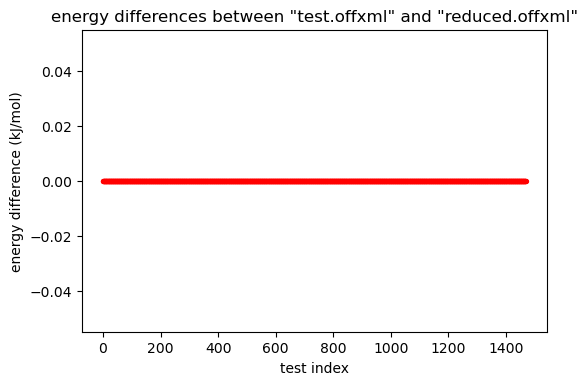

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(energy_diff_list)
df.columns = ['ff_energy', 'ff_reduced_energy', 'difference', 'ff_time', 'ff_reduced_time']
df.to_csv("temp_energy_test_data.csv")

# convert to floats
df['difference'] = df['difference'].apply(lambda x: x._value)

fig1 = plt.figure(1, dpi=100)
plt.scatter(df.index, df.difference, c='r', s=8)
plt.ylabel('energy difference (kJ/mol)')
plt.xlabel('test index')
plt.title('energy differences between \"test.offxml\" and \"reduced.offxml\"')
plt.show()


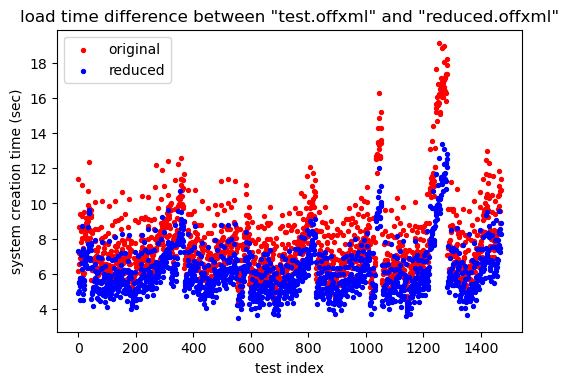

In [37]:
fig2 = plt.figure(2, dpi=100)
plt.scatter(df.index, df.ff_time, c='r', s=8, label='original')
plt.scatter(df.index, df.ff_reduced_time, c='b', s=8, label='reduced')
plt.ylabel('system creation time (sec)')
plt.xlabel('test index')
plt.title('load time difference between \"test.offxml\" and \"reduced.offxml\"')
plt.legend()
plt.show()

In [43]:
from statistics import mean
original_avg_time = float(mean(df.ff_time))
reduced_avg_time = float(mean(df.ff_reduced_time))
print(f"original average time: {original_avg_time}")
print(f"reduced average time: {reduced_avg_time}")
print(f"overall speed up of {(original_avg_time - reduced_avg_time) / original_avg_time * 100: .1f} %")



original average time: 7.901263010745146
reduced average time: 6.146197618432597
overall speed up of  22.2 %
